In [1]:
import librosa
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
from torchaudio import transforms

C:\Users\Luis\miniconda3\envs\audigest\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
SAMPLE_RATE = 44100
MAX_SAMPLES = 44100
SAMPLE_INTERVAL = 1.0/30.0  # 30 fps
WINDOW_LEN = 0.025  # 25 ms
N_MFCC = 20
FPS = 30

In [3]:
lv = 2
n_audio = '004'
audio_path = f'processed_data/test/M003/contempt/level_{lv}/audio/{n_audio}.wav'
clean_audio_path = f'processed_data/test/M003/contempt/level_{lv}/clean_audio/{n_audio}.wav'
landmarks_path = f'processed_data/test/M003/contempt/level_{lv}/landmarks/{n_audio}.npy'

In [4]:
landmarks = np.load(landmarks_path)
print(landmarks.shape)

(82, 468, 3)


# Torchaudio

In [5]:
def convert_to_mono(s):
    if s.shape[0] > 1:
        s = torch.mean(s, dim=0, keepdim=True)
    return s

In [6]:
signal, sr = torchaudio.load(audio_path)
cln_signal, cln_sr = torchaudio.load(clean_audio_path)
signal = convert_to_mono(signal)
cln_signal = convert_to_mono(cln_signal)
signal = signal.flatten()
cln_signal = cln_signal.flatten()
print('normal signal:', signal.shape, 'sample rate:', sr)
print('clean signal:', cln_signal.shape, 'sample rate:', cln_sr)
print('signal min value:', signal.min())
print('signal max value:', signal.max())

normal signal: torch.Size([116736]) sample rate: 48000
clean signal: torch.Size([116736]) sample rate: 48000
signal min value: tensor(-0.2789)
signal max value: tensor(0.3280)


In [7]:
mfcc_transform = transforms.MFCC(
    sample_rate=sr,
    n_mfcc=N_MFCC,
    #log_mels=True,
    melkwargs={
        'n_fft': int(math.ceil(WINDOW_LEN * sr)),
        'hop_length': int(math.ceil(SAMPLE_INTERVAL * sr))
    }
)

C:\Users\Luis\miniconda3\envs\audigest\lib\site-packages\torchaudio\functional\functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (601) may be set too low.
  warnings.warn(


In [8]:
mfcc = mfcc_transform(signal)
mfcc_clean = mfcc_transform(cln_signal)
print('mfcc:', mfcc.shape)
print('mfcc clean:', mfcc_clean.shape)
print('mfcc min:', mfcc.min())
print('mfcc max:', mfcc.max())
print('equal:', bool((torch.sum(torch.eq(mfcc, mfcc_clean))/mfcc.nelement()).item()))

mfcc: torch.Size([20, 73])
mfcc clean: torch.Size([20, 73])
mfcc min: tensor(-523.0038)
mfcc max: tensor(250.3895)
equal: True


In [9]:
mean, std = torch.mean(mfcc, dim=0), torch.std(mfcc, dim=0)
mean_cl, std_cl = torch.mean(mfcc_clean, dim=0), torch.std(mfcc_clean, dim=0)
print('mfcc mean:', mean.shape)
print('mfcc std:', std.shape)

mfcc mean: torch.Size([73])
mfcc std: torch.Size([73])


In [10]:
mfcc = (mfcc - mean) / std
print('mfcc:', mfcc.shape)

mfcc: torch.Size([20, 73])


In [11]:
pad_front = torch.zeros(N_MFCC, 15)
pad_back = torch.zeros(N_MFCC, 15)

In [12]:
mfcc = torch.column_stack((pad_front, mfcc, pad_back))
print(mfcc.shape)

torch.Size([20, 103])


In [13]:
seq_len = mfcc.shape[1]
input_list = []
for i in range(15, seq_len - 15):
    input_list.append(mfcc[:, i - 15:i + 15])
print(len(input_list))

73


# Librosa

In [18]:
signal_lb, sr_lb = librosa.load(audio_path, sr=SAMPLE_RATE)
cln_signal_lb, cln_sr_lb = librosa.load(clean_audio_path, sr=SAMPLE_RATE)
print('normal signal:', signal_lb.shape, 'sample rate:', sr_lb)
print('clean signal:', cln_signal_lb.shape, 'sample rate:', cln_sr_lb)
print('signal min value:', signal_lb.min())
print('signal max value:', signal_lb.max())
print((signal_lb == cln_signal_lb).all())

normal signal: (120423,) sample rate: 44100
clean signal: (120423,) sample rate: 44100
signal min value: -0.22887345
signal max value: 0.20860986
True


In [10]:
signal_len = signal_lb.shape[0]
if signal_len > MAX_SAMPLES:
    signal_lb = signal_lb[:MAX_SAMPLES]
print(signal_lb.shape)

(44100,)


In [19]:
def get_mfccs(shorted, complete, sr):
    n_fft = int(math.ceil(WINDOW_LEN * sr))
    hop_length = int(math.ceil(SAMPLE_INTERVAL * sr))
    
    sliced_melpec = None
    if shorted is not None:
        sliced_melpec = librosa.feature.melspectrogram(y=shorted, sr=sr, n_fft=n_fft, hop_length=hop_length)
        sliced_melpec = librosa.core.spectrum.power_to_db(sliced_melpec)
    melspec = librosa.feature.melspectrogram(y=complete, sr=sr, n_fft=n_fft, hop_length=hop_length)
    melspec = librosa.core.spectrum.power_to_db(melspec)
    mfccs = librosa.feature.mfcc(S=melspec, n_mfcc=N_MFCC)

    return sliced_melpec, melspec, mfccs

In [20]:
s, m, mf = get_mfccs(signal_lb, cln_signal_lb, SAMPLE_RATE)
print(s.shape)
print(m.shape)
print(mf.shape)

(128, 82)
(128, 82)
(20, 82)


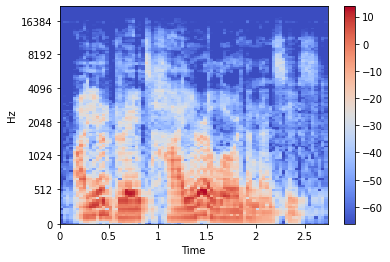

In [79]:
import librosa.display
librosa.display.specshow(s, sr=SAMPLE_RATE, hop_length = int(math.ceil(SAMPLE_INTERVAL * SAMPLE_RATE)), x_axis='time', y_axis='mel');
plt.colorbar();

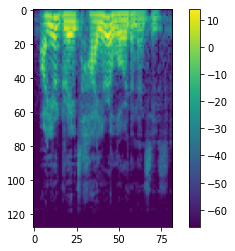

In [83]:
spec_plot = plt.imshow(s)
plt.colorbar(spec_plot)
plt.show()

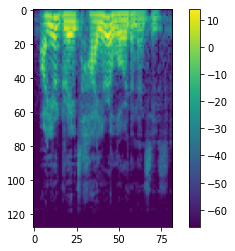

In [22]:
spec_plot = plt.imshow(m)
plt.colorbar(spec_plot)
plt.show()

In [114]:
_, melspec_lb, mfcc_lb = get_mfccs(None, signal_lb, sr_lb)
_, melspec_cl_lb, mfcc_cl_lb = get_mfccs(None, cln_signal_lb, cln_sr_lb)
print('mfcc:', mfcc_lb.shape)
print('melspec:', melspec_lb.shape)
print('mfcc clean:', mfcc_cl_lb.shape)
print('melspec clean:', melspec_cl_lb.shape)
print('mfcc min:', mfcc_lb.min())
print('mfcc max:', mfcc_lb.max())
print('melspec min:', melspec_lb.min())
print('melspec max:', melspec_lb.max())
print('equal mfcc:', (mfcc_lb == mfcc_cl_lb).all())
print('equal melspec:', (melspec_lb == melspec_cl_lb).all())

mfcc: (20, 82)
melspec: (128, 82)
mfcc clean: (20, 82)
melspec clean: (128, 82)
mfcc min: -732.82776
mfcc max: 260.10852
melspec min: -66.23929
melspec max: 13.760708
equal mfcc: True
equal melspec: True


In [20]:
mfccs_delta = librosa.feature.delta(mfcc_lb)
mfcc_lb = np.concatenate((mfcc_lb, mfccs_delta), axis=0)
print(mfcc_lb.shape)

(40, 82)


In [25]:
mean_lb, std_lb = np.mean(mfcc_lb, axis=0), np.std(mfcc_lb, axis=0)
mean_cl_lb, std_cl_lb = np.mean(mfcc_cl_lb, axis=0), np.std(mfcc_cl_lb, axis=0)
print('mfcc mean:', mean_lb.shape)
print('mfcc std:', std_lb.shape)
print('mfcc mean:', mean_cl_lb.shape)
print('mfcc std:', std_cl_lb.shape)

mfcc mean: (82,)
mfcc std: (82,)
mfcc mean: (82,)
mfcc std: (82,)


In [26]:
mfcc_lb = (mfcc_lb - mean_lb) / std_lb
print('mfcc:', mfcc_lb.shape)

mfcc: (20, 82)
melspec: (128, 82)


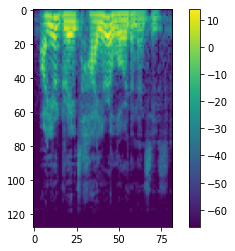

In [115]:
spec_plot = plt.imshow(melspec_lb)
plt.colorbar(spec_plot)
plt.show()

In [25]:
lb_pad_front = np.zeros((40, 15))
lb_pad_back = np.zeros((40, 15))

In [116]:
ms_pad_front = np.full((128, 15), fill_value=melspec_lb.min())
ms_pad_back = np.full((128, 15), fill_value=melspec_lb.min())

In [26]:
mfcc_lb = np.column_stack((lb_pad_front, mfcc_lb, lb_pad_back))
print(mfcc_lb.shape)

(40, 112)


(128, 112)


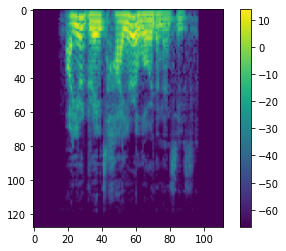

In [117]:
melspec_lb = np.column_stack((ms_pad_front, melspec_lb, ms_pad_back))
print(melspec_lb.shape)
spec_plot = plt.imshow(melspec_lb)
plt.colorbar(spec_plot)
plt.show()

In [28]:
lb_seq_len = mfcc_lb.shape[1]
lb_input_list = []
for i in range(15, lb_seq_len - 15):
    lb_input_list.append(mfcc_lb[:, i - 15:i + 15])
print(np.array(lb_input_list).shape)

(82, 40, 30)


In [118]:
lb_seq_len = melspec_lb.shape[1]
lb_input_list = []
for i in range(15, lb_seq_len - 15):
    lb_input_list.append(melspec_lb[:, i - 15:i + 15])
melspecs = np.array(lb_input_list)
print(melspecs.shape)

(82, 128, 30)


In [132]:
def graph_melspecs(melspecs, cols, rows, start_from=0, size=(10,10)):
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=size)
    for i in range(cols):
        for j in range(rows):
            selected = melspecs[start_from + i * rows + j]
            img = axs[j,i].imshow(selected)
    fig.colorbar(img, ax=axs)
    
    plt.show()

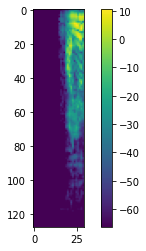

In [120]:
spec_plot = plt.imshow(melspecs[0])
plt.colorbar(spec_plot)
plt.show()

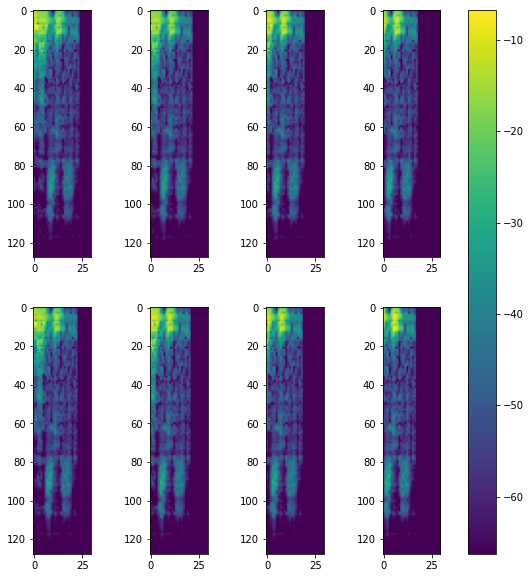

In [133]:
graph_melspecs(melspecs, 4, 2, 73, (10,10))

In [30]:
mse = 0.0
n = len(lb_input_list)
print(n)
# for i in range(n):
#     mse += torch.square(input_list[i] - lb_input_list[i]).mean().item()
# mse /= n
# print(f'mse: {mse}')

82
